# Q Learning 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import random

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) # total number of actions
gridSize = 5 # create a square grid of gridSize by gridSize
state_count = gridSize*gridSize # total number of states

In [3]:
class Gridworld():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        self.new_pos = [0, 0] # initialize new position for p_transition
        self.transition_prob = 1 # deterministic
    
    def initial_state(self):        # return initial state
        return grid.states[gridSize*gridSize-1]
   
    def transition_reward(self, current_pos, action): # return the transition probability

        # get next position: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_pos = np.array(current_pos) + np.array(action)

        # normally, reward = 0
        reward = 0

        # if new pos results in off the grid, return reward -1
        if -1 in self.new_pos or self.size in self.new_pos:
            reward = -1
        # if in state A, receive + 10
        if current_pos == [0, 1]:
            reward = 10
        # if in state B, receive + 5
        if current_pos == [0, 3]:
            reward = 5

        # if taking an action crosses the border; agent's new_pos is the same as the current pos
        if -1 in self.new_pos or self.size in self.new_pos: 
            self.new_pos = current_pos
            
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            self.new_pos = [4, 1]
            
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            self.new_pos = [2, 3]

        return self.new_pos, reward

## Define Functions

In [6]:
# define a function that chooses action based on epsilon-greedy
def choose_action(state, epsilon):
    
    # choose an action type: explore or exploit
    action_type = int(np.random.choice(2, 1, p=[epsilon,1-epsilon]))

    # find best action based on Q values
    best_action_index = np.argmax(Q_values[state])

    # pick a random action
    random_action_index = random.choice(range(4))

    # while random action is the same as the best action, pick a new action
    while random_action_index == best_action_index:
        random_action_index = random.choice(range(4))

    # choose an action based on exploit or explore
    if action_type == 0:
        # explore
        # print("explore")
        action_index = random_action_index
    else:
        # exploit
        # print("exploit")
        action_index = best_action_index
        
    return action_index

In [7]:
# define average function
def Average(lst): 
    return sum(lst) / len(lst) 

In [8]:
# define a function that generates an episode
def generate_episode(steps):

    # set initial state
    state_vector = grid.initial_state()

    # initialize state (with iniitial state), action list and reward list
    state_list = [state_vector]
    action_list = []
    reward_list = []

    # generate an episode
    for i in range(steps):

        # pick an action based on categorical distribution in policy
        action_index = int(np.random.choice(action_count, 1, p=policy[grid.states.index(state_vector)])) 
        action_vector = actions[action_index] # convert the integer index (ie. 0) to action (ie. [-1, 0])

        # get new state and reward after taking action from current state
        new_state_vector, reward = grid.transition_reward(state_vector, action_vector)
        state_vector = list(new_state_vector)

        # save state, action chosen and reward to list
        state_list.append(state_vector)
        action_list.append(action_vector)
        reward_list.append(reward)
        
    return state_list, action_list, reward_list

## Q Learning Algorithm 

In [5]:
# create a grid object
grid = Gridworld(5)

# initialize q values for all state action pairs
Q_values = np.zeros((state_count, action_count))

# initialize other parameters
gamma = 0.1
lr = 0.1
epsilon = 0.1

# define lists for plots
average_reward_list = []
cumulative_reward_list = []
cumulative_reward = 0
delta_list = []
cumulative_test_reward_list = []
average_test_reward_list = []

In [9]:
# iterate over 500 episodes
for episode in range(500):

    # initialize state (output: [4, 4])
    state = grid.initial_state()

    reward_list = []
    delta = 0
    
    # iterate over 200 steps within each episode
    for step in range(200):

        # get state index (output: 24)
        state_index = grid.states.index(state)

        # choose an action based on epsilon-greedy (output: action index ie. 0)
        action_index = choose_action(state_index, epsilon)
        action_vector = actions[action_index] # convert action_index (0) to action_vector ([-1, 0])

        # get the next state and reward after taking the chosen action in the current state
        next_state_vector, reward = grid.transition_reward(state, action_vector)
        next_state_index = grid.states.index(list(next_state_vector))

        # add reward to list
        reward_list.append(reward)
        
        # calculate max delta change for plotting max q value change
        Q_value = Q_values[state_index][action_index] + lr*(reward + gamma*np.max(Q_values[next_state_index])-Q_values[state_index][action_index])
        delta = max(delta, np.abs(Q_value - Q_values[state_index][action_index]))   
        
        # update Q value
        Q_values[state_index][action_index] = Q_values[state_index][action_index] + lr*(reward + gamma*np.max(Q_values[next_state_index])-Q_values[state_index][action_index])

        # set the next state as the current state
        state = list(next_state_vector)
    
    # append max change in Q value to list
    delta_list.append(delta)
    
    # average rewards
    average_reward_list.append(Average(reward_list))
    
    # add cumulative reward
    cumulative_reward = cumulative_reward + sum(reward_list)
    cumulative_reward_list.append(cumulative_reward)
    
    # initialize q values for all state action pairs
    policy = np.zeros((state_count, action_count))
    
    # Generate Greedy policy based on Q_values after each episode
    for state in range(len(Q_values)):
        # find the best action at each state
        best_action = np.argmax(Q_values[state])
        # write deterministic policy based on Q_values
        policy[state][best_action] = 1
    
    # Generate test trajectory with the greedy policy
    state_list, action_list, test_reward_list = generate_episode(200)
    
    # sum up all the rewards obtained during test trajectory and append to list
    cumulative_test_reward_list.append(sum(test_reward_list))

## Plots 

Text(0, 0.5, 'Reward')

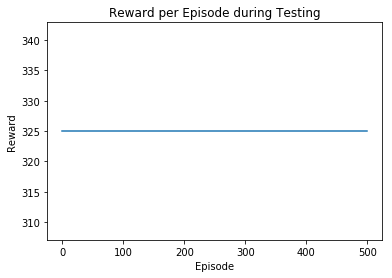

In [10]:
# test reward of each episode, where delta is the change in Q values
plt.plot(cumulative_test_reward_list)
plt.title('Reward per Episode during Testing')
plt.xlabel('Episode')
plt.ylabel('Reward')

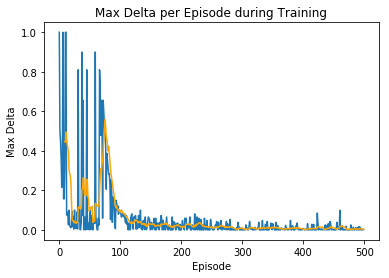

In [11]:
# max delta of each episode, where delta is the change in Q values
plt.plot(delta_list)
plt.title('Max Delta per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Max Delta')

# plot moving average
delta_frame = pd.DataFrame(delta_list)
rolling_mean = delta_frame.rolling(window=10).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

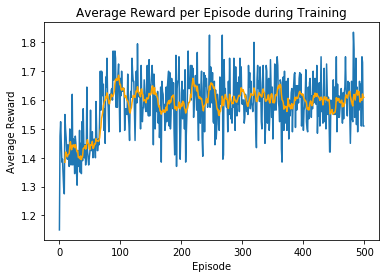

In [12]:
# average reward per episode
plt.plot(average_reward_list)
plt.title('Average Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

# plot moving average
reward_frame = pd.DataFrame(average_reward_list)
rolling_mean = reward_frame.rolling(window=10).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

Text(0, 0.5, 'Cumulative Reward')

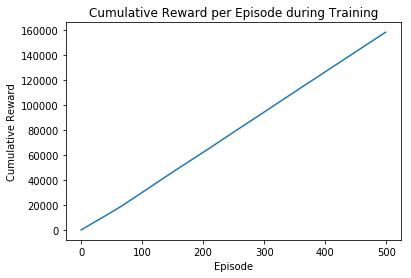

In [13]:
# cumulative reward per episode
plt.plot(cumulative_reward_list)
plt.title('Cumulative Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

In [14]:
np.set_printoptions(precision=4)
Q_values

array([[-8.9924e-01,  1.0000e+00,  9.8795e-03, -8.8808e-01],
       [ 1.0000e+01,  1.0000e+01,  1.0000e+01,  1.0000e+01],
       [-8.8200e-01,  5.0050e-01,  8.0187e-03,  1.0000e+00],
       [ 5.0050e+00,  5.0050e+00,  5.0050e+00,  5.0050e+00],
       [-1.8535e-01, -2.7097e-01,  3.8210e-03,  4.8503e-01],
       [ 1.0000e-01,  9.9754e-02,  9.8676e-04, -9.6993e-01],
       [ 1.0000e+00,  1.0000e-02,  1.0000e-02,  1.0000e-02],
       [ 1.0000e-01,  4.8658e-02,  8.9962e-04,  9.5459e-02],
       [ 5.0050e-01,  5.0050e-03,  5.0050e-03,  1.0000e-02],
       [ 4.3113e-02, -9.6425e-01,  4.9531e-04,  5.0050e-02],
       [ 1.0000e-02,  9.9031e-03,  9.8329e-05, -9.8931e-01],
       [ 1.0000e-01,  1.0000e-03,  1.0000e-03,  1.0000e-03],
       [ 9.7629e-03,  4.9310e-03,  9.5401e-05,  1.0000e-02],
       [ 5.0050e-02,  5.0050e-04,  5.0050e-04,  1.0000e-03],
       [ 5.0050e-03, -9.7698e-01,  4.5554e-05,  4.8503e-03],
       [ 1.0000e-03,  9.4186e-04,  9.4740e-06, -9.8660e-01],
       [ 1.0000e-02,  1.

## Visualize Final Policy 

In [15]:
# PRINT POLICY TABLE ################################################################################
# define column and index
columns=range(grid.size)
index = range(grid.size)
# define dataframe to represent policy table
policy_table = pd.DataFrame(index = index, columns=columns)

# iterate through policy to make a table that represents action number
# as action name (eg. left, right, up, down)
for state in range(len(Q_values)):
    
    # find the best action at each state
    best_action = np.argmax(Q_values[state])

    # get action name
    if best_action == 0:
        action_name = 'up'
    elif best_action == 1:
        action_name = 'right'
    elif best_action == 2:
        action_name = 'down'
    else:
        action_name = 'left'

    # calculate the row and column coordinate of the current state number
    row = int(state/grid.size)
    column = round((state/grid.size - int(state/grid.size))*grid.size)
            
    # assign action name
    policy_table.loc[row][column] = action_name

print("Policy Table: ")
print(policy_table)
print()

Policy Table: 
       0   1     2   3     4
0  right  up  left  up  left
1     up  up    up  up  left
2     up  up  left  up    up
3     up  up    up  up    up
4     up  up  left  up    up

